Compute average IoU and accuracy of phrase localization methods

In [1]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [2]:
import numpy as np
import chainer
from chainer.iterators import SerialIterator
from func.datasets.datasets import BBoxDataset, PLCLCBBoxDataset, DDPNBBoxDataset
from func.datasets.converters import cvrt_bbox
from chainercv.utils import bbox_iou
from IPython.html.widgets import IntProgress
from IPython.display import display
from nltk.metrics import edit_distance

/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
def eval_phrase_localization_gtroi():
    data = BBoxDataset('val')

    ip = IntProgress(min=0, max=len(data))
    display(ip)

    ious = []

    for i in range(len(data)):
        batch = [data[i]]
        gt_roi = batch[0][1]
        im, roi = cvrt_bbox(batch, None, aspect_band=2/3, offset_band=0.4)
        iou = bbox_iou(roi, gt_roi[None, :])[0]
        ious.append(iou)
        ip.value = i
    
    return np.asarray(ious)

# def lget_bbox(df, img_id, phr):
#     ymin = df.at[(img_id, phr), 'ymin']
#     xmin = df.at[(img_id, phr), 'xmin']
#     ymax = df.at[(img_id, phr), 'ymax']
#     xmax = df.at[(img_id, phr), 'xmax']
#     return np.asarray([[ymin, xmin, ymax, xmax]]).astype('f')

def lget_bbox(df, img_id, phr):
    rows = df.query('image==%s'%img_id)
    dist = list(
            map(lambda x: edit_distance(phr.lower(), x), rows.phrase))
    row = rows.iloc[np.argmin(dist)]
    return np.asarray([[row.ymin, row.xmin, row.ymax, row.xmax]])
    
def eval_phrase_localization(pl_type='plclc'):
    gt_data = BBoxDataset('val')
    
    if pl_type=='plclc':
        pl_data = PLCLCBBoxDataset('val')
    elif pl_type=='ddpn':
        pl_data = DDPNBBoxDataset('val')
    else:
        raise RuntimeError
    
    pred_df = pl_data.df
    N = len(gt_data)
    ip = IntProgress(min=0, max=N)
    display(ip)

    ious = []

    for i in range(N):
        row = gt_data.df.iloc[i]
        img_id, phr = row.name
        gt_roi = row.values[:4]
        
        try:
            pred_roi = lget_bbox(pred_df, str(img_id), phr)
            iou = bbox_iou(gt_roi[None, :], pred_roi)[0]
            ious.append(iou)
            ip.value = i
        except:
            print('error')
            pass
    
    return np.asarray(ious)

IntProgress(value=0, max=11745)

accuracy: 52.53
avr. IoU: 0.48


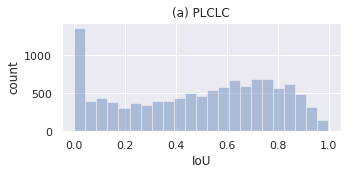

In [5]:
plclc_iou = eval_phrase_localization('plclc')
print('accuracy: %.2f' % (100 * np.sum(plclc_iou >= .5) / len(plclc_iou)))
print('avr. IoU: %.2f' % (plclc_iou.mean()))
plt.close('all')
plt.figure(figsize=(5,2))
sns.distplot(plclc_iou, kde=False)
plt.xlabel('IoU')
plt.ylabel('count')
plt.title('(a) PLCLC')
plt.savefig('figures/cvpr/plclc-IoU.pdf', bbox_inches='tight')

IntProgress(value=0, max=11745)

accuracy: 80.40
avr. IoU: 0.67


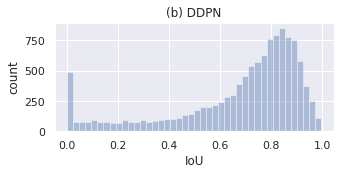

In [6]:
ddpn_iou = eval_phrase_localization('ddpn')
print('accuracy: %.2f' % (100 * np.sum(ddpn_iou >= .5) / len(ddpn_iou)))
print('avr. IoU: %.2f' % (ddpn_iou.mean()))
plt.close('all')
plt.figure(figsize=(5,2))
sns.distplot(ddpn_iou, kde=False)
plt.xlabel('IoU')
plt.ylabel('count')
plt.title('(b) DDPN')
plt.savefig('figures/cvpr/ddpn-IoU.pdf', bbox_inches='tight')

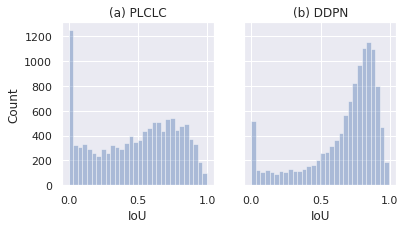

In [8]:
# sns.set_context("poster")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

sns.distplot(plclc_iou, kde=False, ax=ax1, bins=30)
ax1.set_title('(a) PLCLC')
ax1.set_ylabel('Count')
ax1.set_xlabel('IoU')

sns.distplot(ddpn_iou, kde=False, ax=ax2, bins=30)
ax2.set_title('(b) DDPN')
ax2.set_xlabel('IoU')
plt.savefig('figures/cvpr/IoU_distribute.pdf', bbox_inches='tight')